***Early identification of Parkinson's Disease(PD) based on voice recordings*** <br>=============================================================================<br>
***Its better to identify the patients early for helping them treat early.***

**Domain** : Medical <br>
**Context** : 'To explore and generate value out of patients data'<br>

***Import and Review data***

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from os import system
from IPython.display import Image
from sklearn import metrics

In [4]:
pkd = pd.read_csv("Data - Parkinsons")

In [5]:
pkd.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [6]:
print("Data has {} records and {} attributes".format(*pkd.shape))

Data has 195 records and 24 attributes


### Attribute Information:

name - ASCII subject name and recording number<br>
MDVP:Fo(Hz) - Average vocal fundamental frequency<br>
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency<br>
MDVP:Flo(Hz) - Minimum vocal fundamental frequency<br><br>
****Below measures of variation in fundamental frequency****<br>
MDVP:Jitter(%)<br>MDVP:Jitter(Abs)<br>MDVP:RAP<br>MDVP:PPQ<br>Jitter:DDP<br><br>
****Below measures of variation in amplitude****<br>
MDVP:Shimmer<br>MDVP:Shimmer(dB)<br>Shimmer:APQ3<br>Shimmer:APQ5<br>MDVP:APQ<br>Shimmer:DDA<br><br>
NHR,HNR - Two measures of ratio of noise to total components in the voice<br>
status - Health status of the subject (one) - Parkinson's, (zero) - healthy<br>
RPDE,D2 - Two nonlinear dynamical complexity measures<br>
DFA - Signal fractal scaling exponent<br>
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

### Data Cleansing

**Identifying duplicate rows**

In [7]:
dupli = pkd.duplicated()
sum(dupli)

0

*There are no duplicate rows*

In [8]:
pkd.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

**There are no null values in the rows**

#### Identifying the correlation between the columns

In [9]:
def plot_corr(df, size=24):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

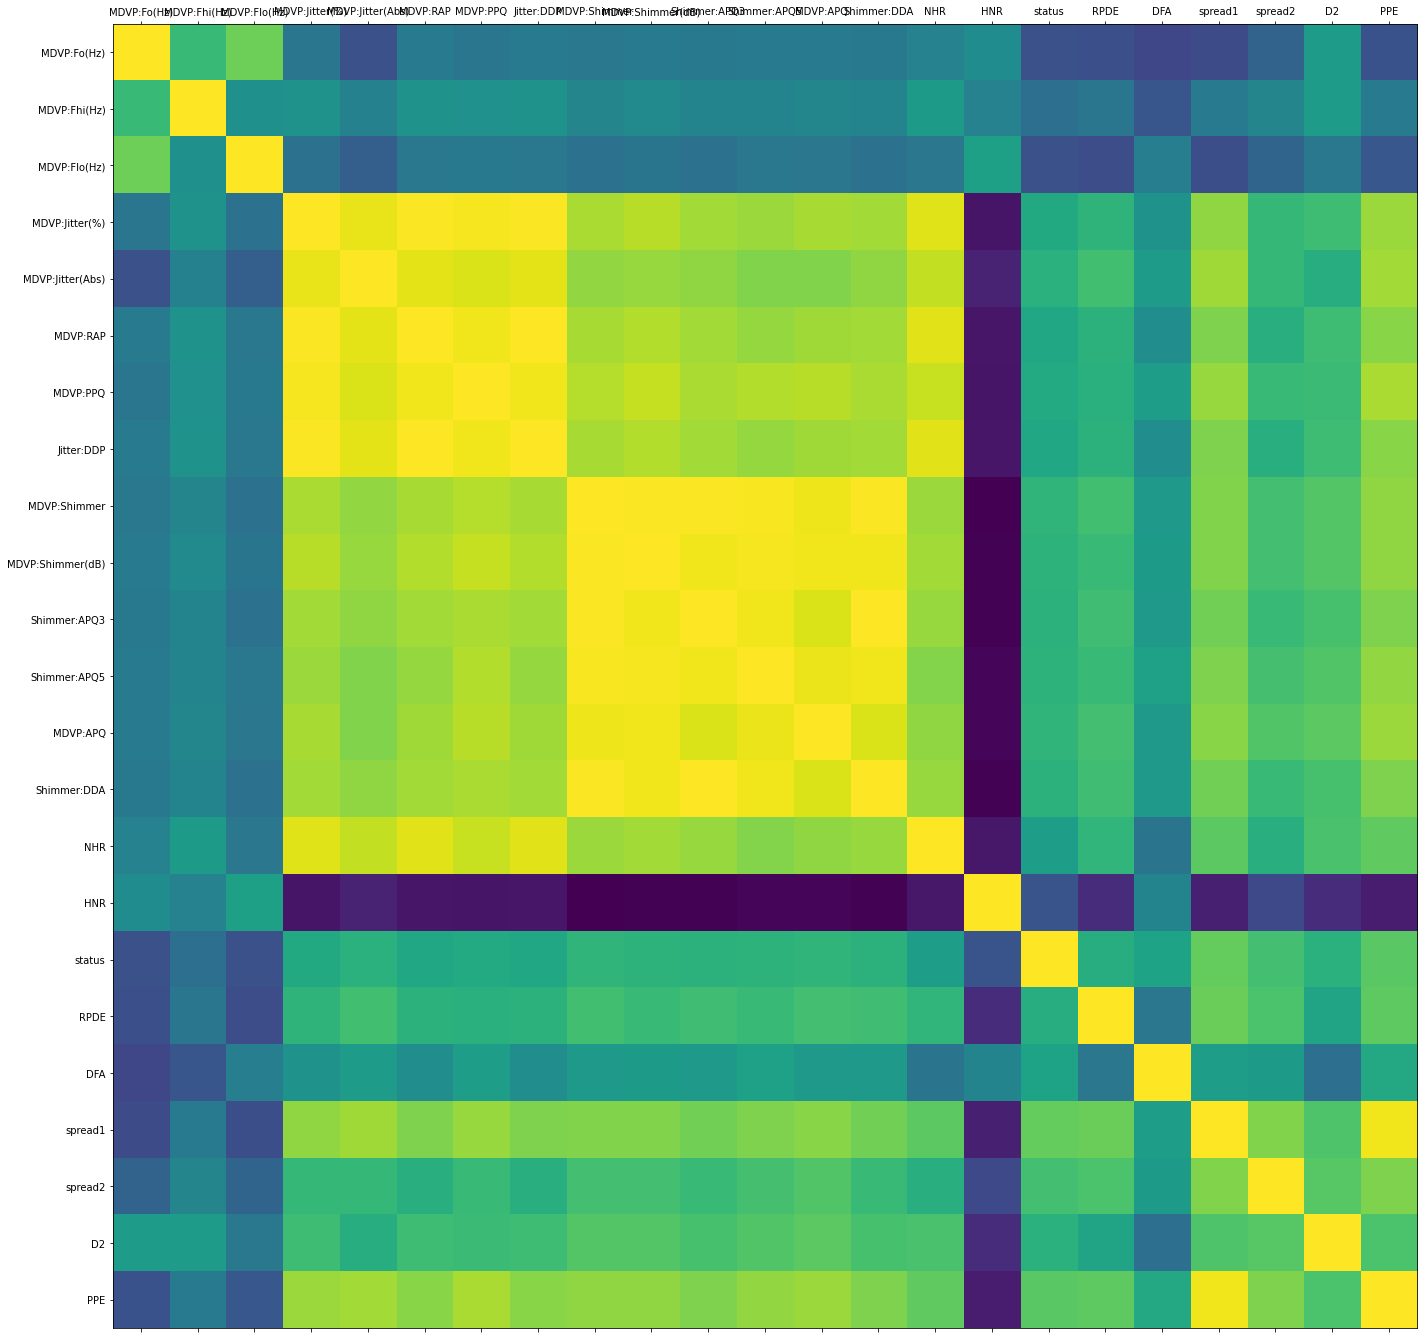

In [10]:
plot_corr(pkd)

Based on the above correlation graph, there are lot of fields having high correlation. High means above 0.95.

##### Identify the columns having correlation higher than .95 and drop the columns to avoid these columns to participate in prediction. By avoiding these columns, additional comutation can be avoided.

In [15]:
cor_matrix = pkd.corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print("Following are the columns to be dropped as the correlation is going higher than 0.95")
print(to_drop)

Following are the columns to be dropped as the correlation is going higher than 0.95
['MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'PPE']


**Dropping the above columns**

In [16]:
pkdc = pkd.drop(to_drop, axis=1)

##### After dropping the features following is the new correlation graph ####

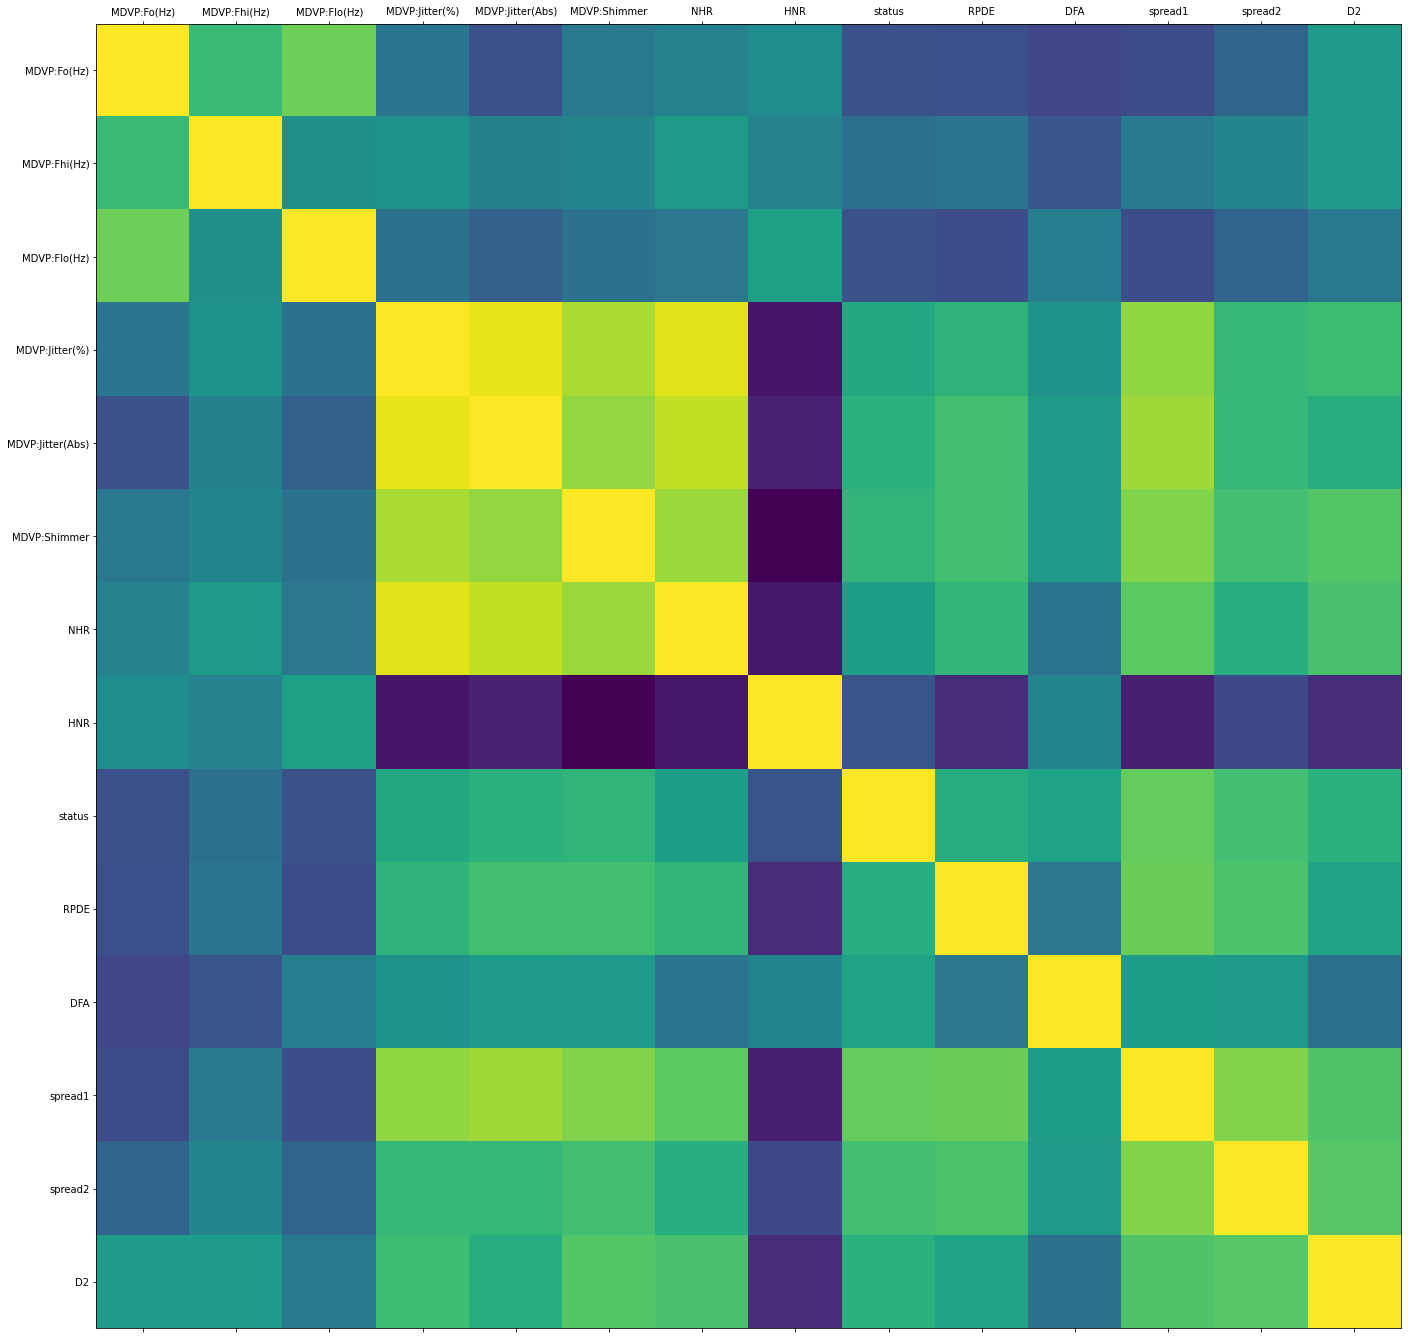

In [20]:
plot_corr(pkdc)

In [21]:
pkdc.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:Shimmer,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.029709,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.018857,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.009540,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.016505,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.022970,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.037885,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.119080,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155


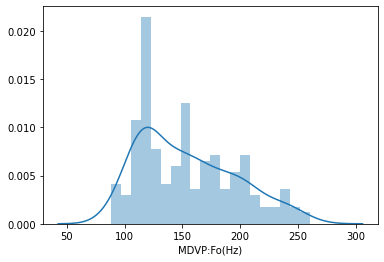

In [27]:
sn.distplot(pkdc['MDVP:Fo(Hz)'], bins = 20)

The above distplot is for avarage fundamental vocal frequency and the data is right skewed

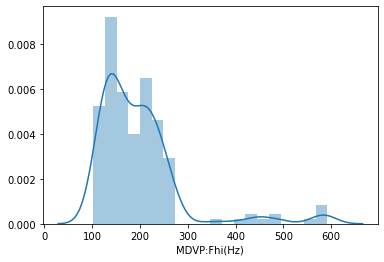

In [29]:
sn.distplot(pkdc['MDVP:Fhi(Hz)'], bins = 20)

The above distribution plot clearly shows that the maximum vocal fundamental frequency is between 100 Hz and 275 Hz. The distribution is skewed right(positively skewed).

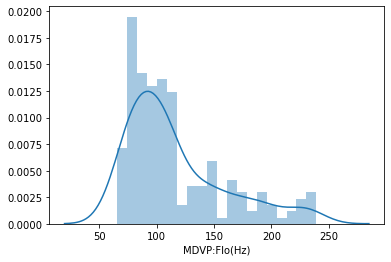

In [30]:
sn.distplot(pkdc['MDVP:Flo(Hz)'], bins = 20)

Minimum vocal fundametal frequency is very high below 120 Hz and goes down from then. The distribution is skewed right(positively skewed).

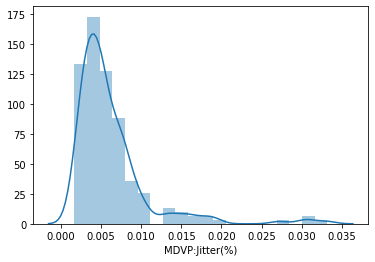

In [31]:
sn.distplot(pkdc['MDVP:Jitter(%)'], bins = 20)

Jitter % is very high at the starting and goes down and the distribution is skewed right.

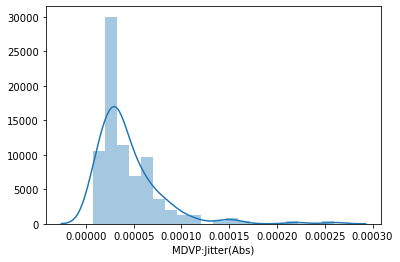

In [32]:
sn.distplot(pkdc['MDVP:Jitter(Abs)'], bins = 20)

Jitter abs is very high at the starting and goes down and the distribution is skewed right, but seems symmetrical around the mean.

Data Distributions


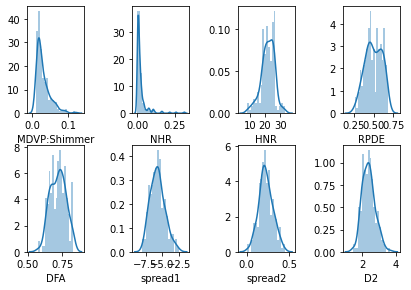

In [61]:
variables = ['MDVP:Shimmer','NHR','HNR','RPDE','DFA','spread1','spread2','D2']
print('Data Distributions')
x=0
y=0
fig, ax =plt.subplots(2,4)
fig.tight_layout()
for i,v in enumerate(variables):
    if i<=3:
        x=0
    else:
        x=1
    if i == 4:
        y=0
    sn.distplot(pkdc[v], bins = 20, ax = ax[x][y])
    y = y+1


**1. MDVP:Shimmer and NHR are looking like right skewed**<br>
**2. HNR, DFA, spread1, spread2 and D2 are symmetrical distribution**<br>
**3. RPDE looks like bimodel splits at 0.50**<br>
**4. There are no missing values in data**

#### Split the dataset into training and test data ####

In [68]:
ftr_attr = pkdc.drop(['status','name'],axis = 1)
prd_attr = pkdc['status']

Name is not required, so droping the column

In [69]:
Zftr_attr = ftr_attr.apply(zscore)
Y = prd_attr.values.reshape(len(prd_attr),)

In [76]:
x_train,x_test,y_train,y_test = train_test_split(Zftr_attr,Y,test_size=0.3,random_state=1)

#### Following are the 3 classification algorithms will be used for the analysis: <br>
    1. Logistic Regression
    2. Naive Baye's
    3. K-NN

#### 1. Logistic Regression ####

Logistic Model Acuurecy : 0.8971

Confusion Matrix :


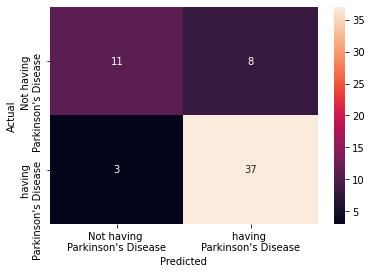

Classification Report :
                                 precision    recall  f1-score   support

Not having 
Parkinson's Disease       0.79      0.58      0.67        19
    having 
Parkinson's Disease       0.82      0.93      0.87        40

                       accuracy                           0.81        59
                      macro avg       0.80      0.75      0.77        59
                   weighted avg       0.81      0.81      0.80        59



In [98]:
lr = LogisticRegression(solver = 'liblinear', multi_class= 'auto')
lr.fit(x_train, y_train)
print("Logistic Model Acuurecy : {0:.4f}\n".format(lr.score(x_train, y_train)))
y_prid = lr.predict(x_test)
print("Confusion Matrix :")
label = ["Not having \nParkinson's Disease","having \nParkinson's Disease"]
ax= plt.subplot()
sn.heatmap(metrics.confusion_matrix(y_test,y_prid),annot=True, ax = ax)
ax.set_xlabel('Predicted');
ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(label); 
ax.yaxis.set_ticklabels(label);
plt.show()
print("Classification Report :")
print(metrics.classification_report(y_test,y_prid,target_names = label))

#### Following are the observations from above results####
* Logistic model is giving 0.89 percent accurcy, this model is not performing well on this data set.

#### 2. K-NN Model ####

KNN Model Acuurecy : 1.0000


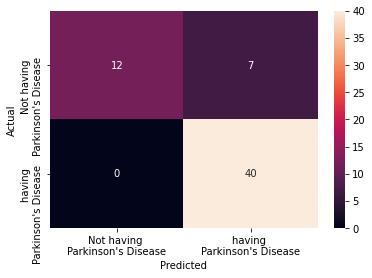

Classification Report :
                                 precision    recall  f1-score   support

Not having 
Parkinson's Disease       1.00      0.63      0.77        19
    having 
Parkinson's Disease       0.85      1.00      0.92        40

                       accuracy                           0.88        59
                      macro avg       0.93      0.82      0.85        59
                   weighted avg       0.90      0.88      0.87        59



In [99]:
NNH = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance' )
NNH.fit(x_train, y_train)
print("KNN Model Acuurecy : {0:.4f}".format(NNH.score(x_train, y_train)))
knn_prid = NNH.predict(x_test)
print("Confusion Matrix :")
label = ["Not having \nParkinson's Disease","having \nParkinson's Disease"]
ax= plt.subplot()
sn.heatmap(metrics.confusion_matrix(y_test,knn_prid),annot=True, ax = ax)
ax.set_xlabel('Predicted');
ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(label); 
ax.yaxis.set_ticklabels(label);
plt.show()
print("Classification Report :")
print(metrics.classification_report(y_test,knn_prid,target_names = label))

#### 3. Navie Baye's ####

Naive Bayes Model Acuurecy : 0.7721

Confusion Matrix :


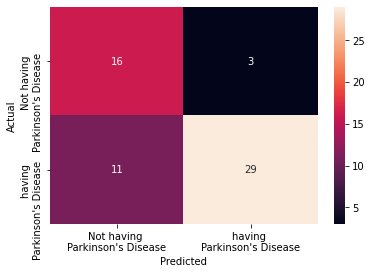

Classification Report :
                                 precision    recall  f1-score   support

Not having 
Parkinson's Disease       0.59      0.84      0.70        19
    having 
Parkinson's Disease       0.91      0.72      0.81        40

                       accuracy                           0.76        59
                      macro avg       0.75      0.78      0.75        59
                   weighted avg       0.81      0.76      0.77        59



In [103]:
pd_model = GaussianNB()
pd_model.fit(x_train, y_train.ravel())
print("Naive Bayes Model Acuurecy : {0:.4f}".format(pd_model.score(x_train, y_train)))
NB_prid = pd_model.predict(x_test)
print("\nConfusion Matrix :")
label = ["Not having \nParkinson's Disease","having \nParkinson's Disease"]
ax= plt.subplot()
sn.heatmap(metrics.confusion_matrix(y_test,NB_prid),annot=True, ax = ax)
ax.set_xlabel('Predicted');
ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(label); 
ax.yaxis.set_ticklabels(label);
plt.show()
print("Classification Report :")
print(metrics.classification_report(y_test,NB_prid,target_names = label))

#### Decision Trees ####

Model Acuurecy on training data : 0.9485
Model Acuurecy on testing data : 0.8305
Acuurecy on training data is high comparing to testing data, acuurecy between these training and test data should be close 
enough to say the model is good fit.

Decision tree :


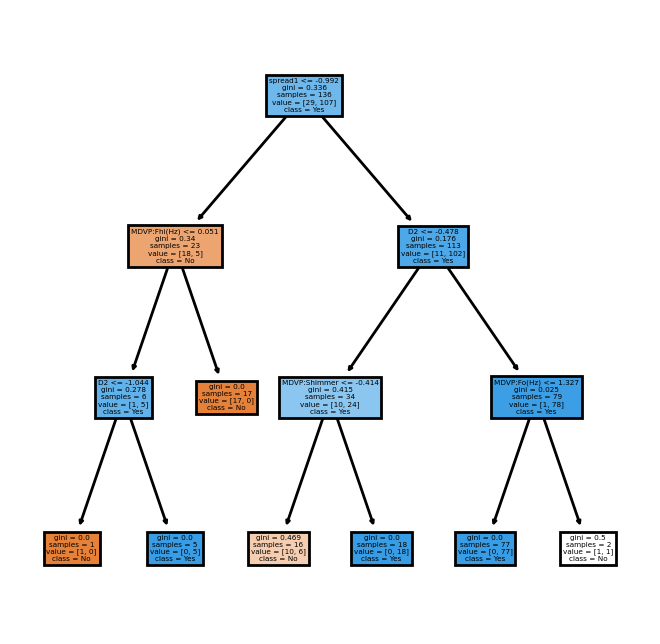

In [160]:
dTree = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTree.fit(x_train, y_train)
print("Model Acuurecy on training data : {0:.4f}".format(dTree.score(x_train, y_train)))
print("Model Acuurecy on testing data : {0:.4f}".format(dTree.score(x_test, y_test)))
print("Acuurecy on training data is high comparing to testing data, acuurecy between these training and test data should be close \nenough to say the model is good fit.")
fn = list(x_train)
cn = ['No', 'Yes']
print("\nDecision tree :")
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=200)
plot_tree(dTree, feature_names = fn, class_names=cn, filled = True,ax=axes)
fig.savefig('tree.png')



Confusion Matrix :


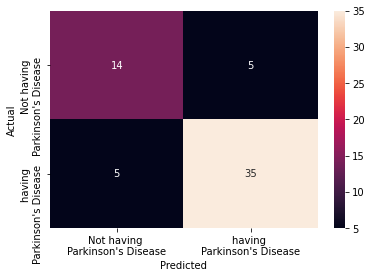

Classification Report :
                                 precision    recall  f1-score   support

Not having 
Parkinson's Disease       0.74      0.74      0.74        19
    having 
Parkinson's Disease       0.88      0.88      0.88        40

                       accuracy                           0.83        59
                      macro avg       0.81      0.81      0.81        59
                   weighted avg       0.83      0.83      0.83        59



In [155]:
y_pred = dTreeR.predict(x_test)
print("\nConfusion Matrix :")
label = ["Not having \nParkinson's Disease","having \nParkinson's Disease"]
ax= plt.subplot()
sn.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True, ax = ax)
ax.set_xlabel('Predicted');
ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(label); 
ax.yaxis.set_ticklabels(label);
plt.show()
print("Classification Report :")
print(metrics.classification_report(y_test,y_pred,target_names = label))

#### Ensemble model ####

1. Bagging

In [170]:
bgcl = BaggingClassifier(base_estimator=dTree, n_estimators=50,random_state=1)
bgcl = bgcl.fit(x_train, y_train)
bg_pred = bgcl.predict(x_test)
print("Bagging acuurecy is : {0:.4f}".format(bgcl.score(x_test , y_test)))

Bagging acuurecy is : 0.8305


### Compare all the models ###

1. Out of all the 5 models KNN model is having high acuurecy of 1.
2. All other models are having acuurecy less than 0.85